# Saturated Broadened Spectrum

In [ ]:
#TODO: Use doppler width to determine scaling factor

In [1]:
import pandas as pd
import scipy.optimize as opt 
from routines import plot_data, four_gauss, plot_interval,gauss
from uncertainties import ufloat
import scipy.fftpack
import scipy.signal as signal
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.patches as patches
from pandas.tools.plotting import table

%pylab inline
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

Populating the interactive namespace from numpy and matplotlib


/home/sebastian/miniconda3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['table']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### -Raw Data

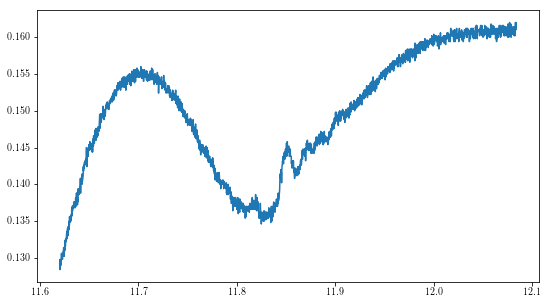

In [2]:
fp = None

# import data


folder = "02-13/saturated/rising"
falling = False

path_saturated = "clean/" + folder + "/saturated.csv"
path_fp = "clean/" + folder + "/fp.csv"
path_doppler = "clean/" + folder + "/doppler.csv"

saturated = pd.DataFrame.from_csv(path_saturated,index_col=None)
fp = pd.DataFrame.from_csv(path_fp,index_col= None)
doppler = pd.DataFrame.from_csv(path_doppler,index_col= None)

#offsets
fp.t = fp.t
fp.V = fp.V/5
saturated = saturated
# show data 
figsize(9,5)
plot(saturated.t,saturated.V)

None

### - Analyze Fabry-Perot

In [3]:
#left maximum
fp_lpeak = np.array(fp[0:math.floor(len(fp.t)/2)].sort_values('V').t)[-1]

#right maximum 
fp_rpeak = np.array(fp[math.floor(len(fp.t)/2):].sort_values('V').t)[-1]

fsr = fp_rpeak - fp_lpeak

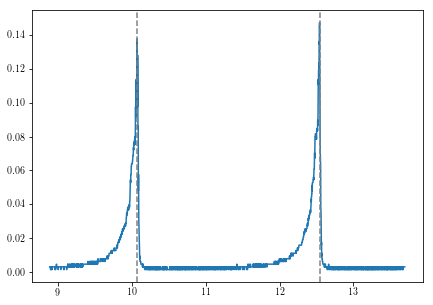

In [4]:
figsize(7,5)
plot(fp.t,fp.V)

axvline(fp_lpeak, ls = '--',color = 'grey')
axvline(fp_rpeak, ls = '--', color = 'grey')    

scale_fsr = 10e3/fsr #MHz

### - Remove Background

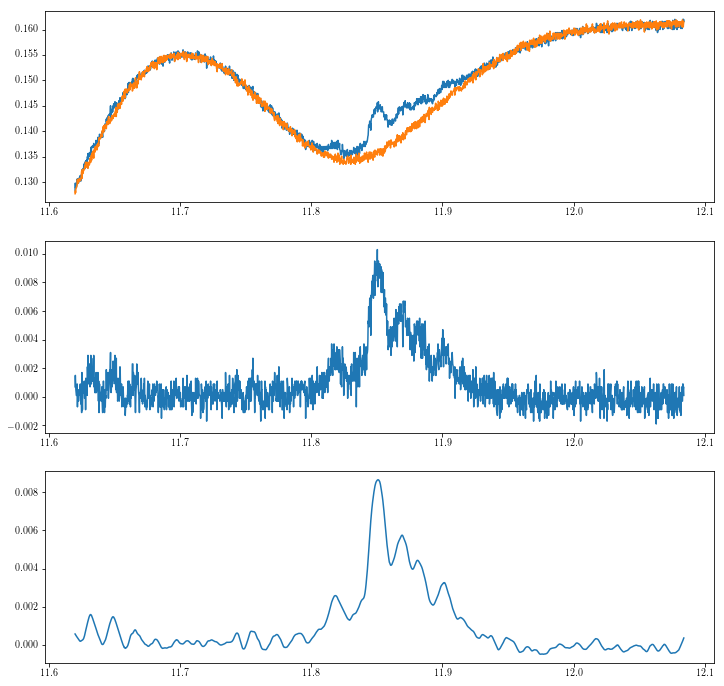

In [93]:
figsize(12,12)
background = doppler.copy()
background.t += 0.016
background.V += 0.0105


merged = pd.merge(background,saturated,how='inner',on=['t'])

sat_nb = pd.DataFrame([merged.t,(merged.V_y-merged.V_x)])
sat_nb = sat_nb.transpose()
sat_nb.columns = ['t','V']
sat_nb.head()

subplot(3,1,1)
plot(merged.t,merged.V_y)
plot(merged.t,merged.V_x)


subplot(3,1,2)
plot(sat_nb.t,sat_nb.V)


filtered = lowess(sat_nb.V,sat_nb.t,frac = 0.018, it=0)

sat_filtered = pd.DataFrame([filtered[:,0],filtered[:,1]])
sat_filtered = sat_filtered.transpose()
sat_filtered.columns = ['t','V']

subplot(3,1,3)
plot(sat_filtered.t,sat_filtered.V)
savefig("./clean/"+ folder + "/data_manip.eps")
None

In [6]:
def lorentzian(x,N,x0,gamma):
    return N/((1+((x-x0)/gamma)**2))

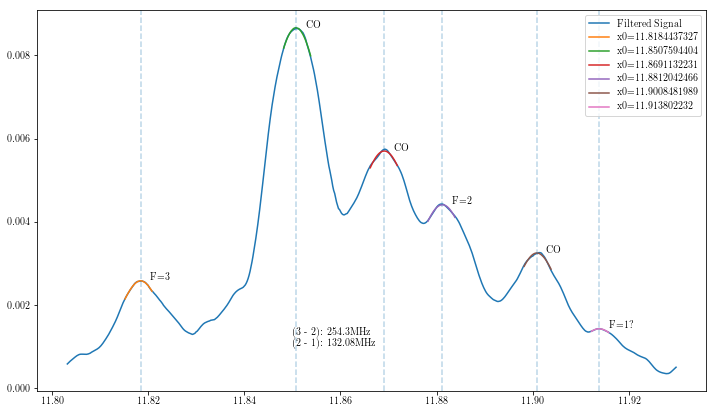

In [92]:
# Fitting areas

figsize(12,7)
width = [0.006,0.006,0.006,0.006,0.006,0.004]
left_pos = [11.815,11.848,11.866,11.878,11.898,11.912]

# truncate data so only important peaks are shown
sat_filtered_trunc = sat_filtered[(sat_filtered.t > (left_pos[0] - 2*width[0])) & 
                                  (sat_filtered.t < (left_pos[-1] + 3*width[0]))]


fig,ax = subplots()
ax.plot(sat_filtered_trunc.t,sat_filtered_trunc.V,label = 'Filtered Signal')

# Plot the fitting areas as shaded rectangles 
i = 0


par_peaks = []
labels = ['F=3','CO','CO','F=2','CO',"F=1?"]
i = 0
 
# Fitting the data for each area and plotting the fitted functions,
# parameters are saved in par_peaks

for x,w in zip(left_pos,width):
    fit_data = sat_filtered_trunc[(sat_filtered_trunc.t > x) & (sat_filtered_trunc.t < (x+w))]
    #ax.plot(fit_data.t,fit_data.V)
    x0 = x+w/2
    N = max(fit_data.V)
    gamma = w
    
    par, cov = opt.curve_fit(lorentzian,fit_data.t,fit_data.V,[N,x0,gamma])
    par_peaks.append(par)
    plt_label = "x0=" + str(par[1])  
    ax.plot(fit_data.t,lorentzian(fit_data.t,*par),label=plt_label)
    ax.annotate(labels[i],xy = (par[1]+0.002,par[0]),textcoords='data')
    axvline(par[1],ls = "--", alpha = .3)
    i+=1

#Data frame with parameters

spectrum = pd.DataFrame(par_peaks)
spectrum.columns = ['y','x','width']
spectrum.index = labels
spectrum.x = (spectrum.x-min(spectrum.x))*scale_fsr

spectrum_nofsr = spectrum.copy()
spectrum_nofsr = spectrum_nofsr/scale_fsr

ax.annotate("(3 - 2): " + str(np.round(spectrum.x['F=2'],2)) + "MHz \n (2 - 1): " + 
            str(np.round(spectrum.x['F=1?']-spectrum.x['F=2'],2)) + "MHz" ,(11.85,0.001))
legend()
savefig("./clean/" + folder + "/hyperfine_spectrum.eps")
None

In [48]:
spectrum.to_html("./clean/" + folder + "/Hyperfine_spectrum.html")

In [49]:
(spectrum.x['F=1?']-spectrum.x['F=2'])/spectrum.x['F=2']

0.51940278023633824

In [50]:
157.1/267.2

0.5879491017964071